In [2]:
!pip install transformers

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [56]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

from datasets import load_dataset

# Function to convert numeric labels to letter labels
def convert_labels(sample):
    if sample['answerKey'].isdigit():
        # Convert numeric labels to letters
        sample['answerKey'] = chr(64 + int(sample['answerKey']))  # '1' -> 'A', '2' -> 'B', etc.
        # Convert each numeric choice in 'choices' to letters
        sample['choices']['text'] = [chr(64 + int(choice)) if choice.isdigit() else choice for choice in sample['choices']['text']]
    return sample

# Load the ARC dataset
arc_dataset = load_dataset('ai2_arc', 'ARC-Challenge')

# Preprocess the dataset to handle numeric labels
arc_dataset = arc_dataset.map(convert_labels)

# Split the dataset into 33% difficulty-train and 66% train
train_test_split = arc_dataset['train'].train_test_split(test_size=0.33, seed=42)
difficulty_train = train_test_split['test']
train = train_test_split['train']

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Map:   0%|          | 0/1172 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

In [16]:
def create_prompt(sample, difficulty_samples):
    prompt = "Choose the correct answers for the following questions, using the letter of the correct answer.\n\n"
    for ds in difficulty_samples:
        prompt += f"Question: {ds['question']}\n"
        for i, choice in enumerate(ds['choices']['text']):
            prompt += f"{chr(65 + i)}. {choice}\n"
        prompt += f"Answer: {ds['answerKey']}\n\n"

    prompt += f"Question: {sample['question']}\n"
    for i, choice in enumerate(sample['choices']['text']):
        prompt += f"{chr(65 + i)}. {choice}\n"
    prompt += "Answer: "
    return prompt


In [37]:
import numpy as np
from tqdm import tqdm

num_difficulty_train_samples = 30  # Number of times to run the process
correct_probs = []
k = 3

for _ in tqdm(range(num_difficulty_train_samples)):
    difficulty_samples = random.sample(list(difficulty_train), k)
    sample = train[2]
    correct_answer = sample['answerKey']
    correct_index = ord(correct_answer) - 65  # Convert 'A' to 0, 'B' to 1, etc.

    # Create the prompt
    prompt = create_prompt(sample, difficulty_samples)
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate the logits
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 1, output_scores=True, return_dict_in_generate=True)

    # Extract the logits for each answer choice
    answer_logits = {}
    num_choices = len(sample['choices']['text'])
    for i in range(num_choices):
        letter = chr(65 + i)  # Convert index to letter (0 -> 'A', 1 -> 'B', etc.)
        token_id = tokenizer.convert_tokens_to_ids(letter)
        # Extract the logits for the token corresponding to the letter
        answer_logits[letter] = outputs.scores[0][0, token_id].item()

    # Convert logits to a tensor
    logits_tensor = torch.tensor([answer_logits[chr(65 + i)] for i in range(num_choices)])

    # Calculate softmax probabilities
    softmax_probs = F.softmax(logits_tensor, dim=0)

    # Get the probability of the correct answer and store it
    correct_prob = softmax_probs[correct_index]
    correct_probs.append(correct_prob.item())

# Calculate mean and standard deviation of the softmax probabilities
mean_prob = np.mean(correct_probs)
std_prob = np.std(correct_probs)

print(f"Mean of Softmax Probabilities of the Correct Answer: {mean_prob}")
print(f"Standard Deviation of Softmax Probabilities of the Correct Answer: {std_prob}")

100%|██████████| 30/30 [00:38<00:00,  1.28s/it]

Mean of Softmax Probabilities of the Correct Answer: 0.4292179077863693
Standard Deviation of Softmax Probabilities of the Correct Answer: 0.03753194568367736


In [ ]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch
import json

M = len(train)  # Number of samples to process
num_difficulty_train_samples = 5  # Number of times to run the process for each sample
k = 3  # Number of difficulty samples for in-context learning

# Store results for each sample
results = []

# Function to create a prompt
def create_prompt(sample, difficulty_samples):
    prompt = "Choose the correct answer for the following question, using the letter of the correct answer.\n\n"
    for ds in difficulty_samples:
        prompt += f"Q: {ds['question']}\n"
        for i, choice in enumerate(ds['choices']['text']):
            prompt += f"{chr(65 + i)}. {choice}\n"
        prompt += f"A: {ds['answerKey']}\n\n"

    prompt += f"Q: {sample['question']}\n"
    for i, choice in enumerate(sample['choices']['text']):
        prompt += f"{chr(65 + i)}. {choice}\n"
    prompt += "A: "
    return prompt

# Run the process num_difficulty_train_samples times
for sample_idx in tqdm(range(M)):
    sample = train[sample_idx]
    correct_answer = sample['answerKey']
    correct_index = ord(correct_answer) - 65  # Convert 'A' to 0, 'B' to 1, etc.

    correct_probs = []

    for _ in range(num_difficulty_train_samples):
        difficulty_samples = random.sample(list(difficulty_train), k)

        # Create the prompt
        prompt = create_prompt(sample, difficulty_samples)
        # Tokenize the prompt
        inputs = tokenizer(prompt, return_tensors='pt')

        # Generate the logits
        outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 1, output_scores=True, return_dict_in_generate=True)

        # Extract the logits for each answer choice
        answer_logits = {}
        num_choices = len(sample['choices']['text'])
        for i in range(num_choices):
            letter = chr(65 + i)  # Convert index to letter (0 -> 'A', 1 -> 'B', etc.)
            token_id = tokenizer.convert_tokens_to_ids(letter)
            # Extract the logits for the token corresponding to the letter
            answer_logits[letter] = outputs.scores[0][0, token_id].item()

        # Convert logits to a tensor
        logits_tensor = torch.tensor([answer_logits[chr(65 + i)] for i in range(num_choices)])

        # Calculate softmax probabilities
        softmax_probs = F.softmax(logits_tensor, dim=0)

        # Ensure correct_index is within bounds
        if correct_index >= num_choices or correct_index < 0:
            print(f"Error: Correct index {correct_index} is out of bounds for num choices {num_choices}")
            continue

        # Get the probability of the correct answer and store it
        correct_prob = softmax_probs[correct_index]
        correct_probs.append(correct_prob.item())

    # Calculate mean and standard deviation of the softmax probabilities
    mean_prob = np.mean(correct_probs)
    std_prob = np.std(correct_probs)

    # Save the results
    results.append({
        'sample_index': sample_idx,
        'mean_prob': mean_prob,
        'std_prob': std_prob,
        'correct_probs': correct_probs
    })

# Save results to a file
with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to 'results.json'")

  1%|          | 6/749 [00:32<1:07:02,  5.41s/it]

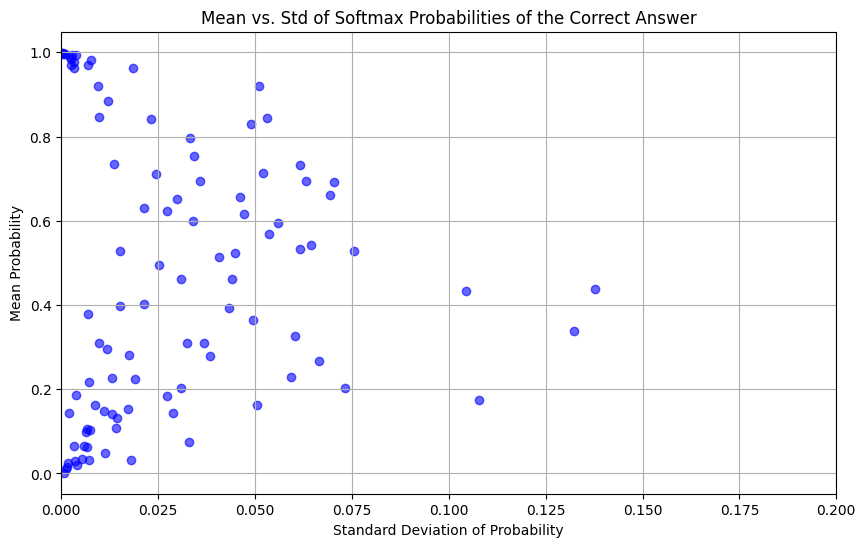

In [74]:
import matplotlib.pyplot as plt
import json

# Load the results from the file
with open('results.json', 'r') as f:
    results = json.load(f)

# Extract mean and std probabilities
mean_probs = [result['mean_prob'] for result in results]
std_probs = [result['std_prob'] for result in results]

# too_big = []
# for i in range(len(std_probs)):
#     if std_probs[i] > 0.1:
#         too_big.append(i)

# # subset of mean_probs without the indexes of too_big
# mean_probs = [mean_probs[i] for i in range(len(mean_probs)) if i not in too_big]
# std_probs = [std_probs[i] for i in range(len(std_probs)) if i not in too_big]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(std_probs, mean_probs, color='blue', alpha=0.6)
plt.title('Mean vs. Std of Softmax Probabilities of the Correct Answer')
plt.ylabel('Mean Probability')
plt.xlabel('Standard Deviation of Probability')
plt.grid(True)
plt.xlim(0, 0.2)
plt.show()

In [7]:
sample_question = arc_dataset['train'][2]

question_text = sample_question['question']
choices = sample_question['choices']['text']
correctAnswer = sample_question['answerKey']

# Create the prompt
prompt = "Choose the correct answer for the following question, using the letter of the correct answer.\n\n"
prompt += "Question: " + question_text + "\n"
for i, choice in enumerate(choices):
    prompt += f"{chr(65 + i)}. {choice}\n"
prompt += "Answer: "

print(f"Prompt:\n{prompt}")

# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors='pt')

# Generate the model's answer
num_return_sequences = 5  # Set the number of sequences you want to return
num_beams = num_return_sequences  # Use the same number of beams as sequences to explore

outputs = model.generate(**inputs, num_return_sequences=num_return_sequences, num_beams=num_beams)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Correct answer: {correctAnswer}")
print(f"Model's answer: {answer}")

Prompt:
Choose the correct answer for the following question, using the letter of the correct answer.

Question: A fold observed in layers of sedimentary rock most likely resulted from the
A. cooling of flowing magma.
B. converging of crustal plates.
C. deposition of river sediments.
D. solution of carbonate minerals.
Answer: 
Correct answer: B
Model's answer: B


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [8]:
a = [tokenizer.decode(outputs[0], skip_special_tokens=True),
tokenizer.decode(outputs[1], skip_special_tokens=True),
tokenizer.decode(outputs[2], skip_special_tokens=True),
tokenizer.decode(outputs[3], skip_special_tokens=True),
tokenizer.decode(outputs[4], skip_special_tokens=True)]
print(a)

['B', 'C', 'D', 'A', 'B.']


Dataset({
    features: ['id', 'question', 'choices', 'answerKey'],
    num_rows: 749
})